In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x_):
    return 3*x_**2 - 4*x_ + 5

In [3]:
f(3.0)

20.0

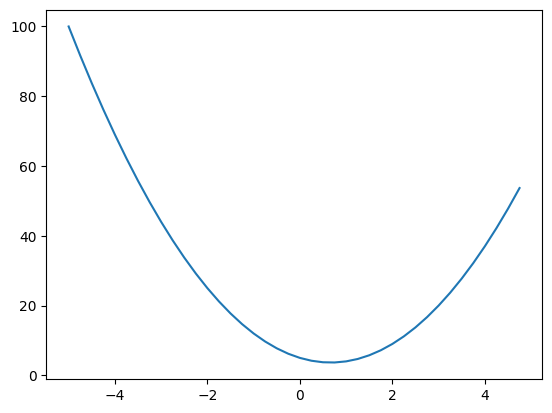

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.0000001
x = 2/3
(f(x + h) - f(x)) / h

2.9753977059954195e-07

In [6]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [7]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
b += h
d2 = a * b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)


d1 4.0
d2 4.0002
slope 2.0000000000042206


In [8]:
class Value:
    def __init__(self, data, _children=(), _op = "", label = ''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self._backward = lambda: None
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __radd__(self, other):
        return self.__add__(other)

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)


    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self.__mul__(other)

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad += other * (self.data**(other - 1)) * out.grad

        out._backward = _backward

        return out

    def __truediv__(self, other):
        return self * (other**-1)

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), "exp")

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for v in reversed(topo):
            v._backward()

In [9]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)

    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))

        dot.node(name = uid, label = f'{n.label} | data {n.data:.4f} | grad {n.grad:.4f}', shape='record')

        if n._op:
            dot.node(name = uid + n._op, label=n._op)

            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [10]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(8, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1+x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

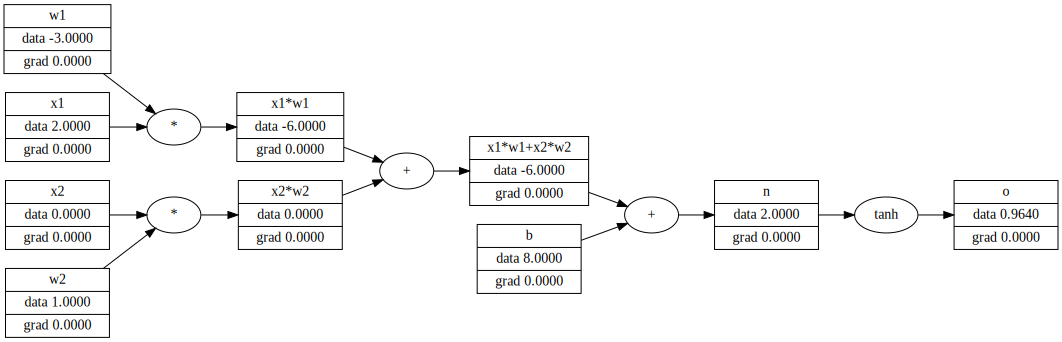

In [11]:
draw_dot(o)

In [12]:
o.backward()

In [13]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(8, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1+x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o = ((2*n).exp() - 1)/((2*n).exp() + 1)

o.label = 'o'

In [72]:
import random


class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1.0, 1.0)) for _ in range(nin)]
        self.b = Value(random.uniform(-1.0, 1.0))

    def __call__(self, x):
        zipped_values = list(zip(self.w, x))

        activation = sum((wi*xi for wi, xi in zipped_values), self.b)
        out = activation.tanh()

        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]

        if len(outs) == 1:
            return outs[0]

        return outs
    
    def parameters(self):
        params = []
        for n in self.neurons:
            params.extend(n.parameters())
        return params

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [129]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.5510461306055793)

In [130]:
n.parameters()

[Value(data=0.10298423339691642),
 Value(data=0.13714347916548042),
 Value(data=-0.789210480695884),
 Value(data=0.7346390945853658),
 Value(data=-0.43461986528532526),
 Value(data=0.9705500691215225),
 Value(data=0.09385076038591067),
 Value(data=-0.42247364496713447),
 Value(data=0.4694969647543412),
 Value(data=0.841271270885626),
 Value(data=0.5963690869836196),
 Value(data=-0.3255803374123467),
 Value(data=0.3728360914773259),
 Value(data=-0.3882569181626043),
 Value(data=0.9890575003136093),
 Value(data=0.9405293412382443),
 Value(data=0.7330791977067743),
 Value(data=0.5648936999918499),
 Value(data=0.8287012305671295),
 Value(data=0.9545759564387202),
 Value(data=0.6085654379473824),
 Value(data=-0.11272643637488189),
 Value(data=0.9446674468961347),
 Value(data=-0.8764499151050156),
 Value(data=0.2783779587156314),
 Value(data=-0.20852312606198087),
 Value(data=-0.6874327301908141),
 Value(data=0.7489159485447792),
 Value(data=0.19151082738055902),
 Value(data=-0.8575910303579

In [131]:
xss = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]

In [ ]:
for k in range(100):
    ypred = [n(x) for x in xss]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])

    for p in n.parameters():
        p.grad = 0.0

    loss.backward()
    for p in n.parameters():
        p.data += -0.01 * p.grad

    print(k, loss.data)


0 5.049674803937162
1 4.720170590496023
2 4.058217472456353
3 3.200139658163552
4 2.5298931417067934
5 2.239664485269204
6 2.0372371346189073
7 1.6312118335995998
8 1.0278920006164
9 0.47734653667948646
10 0.17557120888713978
11 0.064299554942845
12 0.031115617103353112
13 0.022183249911462186
14 0.020940687450569925
15 0.023586257380153828
16 0.028924355577866084
17 0.03152039123996126
18 0.02170146520218854
19 0.00822155724436066
20 0.0021511514664528755
21 0.0005063141977210062
22 0.00012726706746162274
23 3.704264261764127e-05
24 1.2624784153510249e-05
25 4.911431258637107e-06
26 2.109046779187147e-06
27 9.720043608599709e-07
28 4.712475472152488e-07
29 2.3711049584135145e-07
30 1.2269964244034297e-07
31 6.490510353407541e-08
32 3.4950833625946717e-08
33 1.910542668004928e-08
34 1.0581871515138324e-08
35 5.931470569072406e-09
36 3.3626047674268036e-09
37 1.9275577318436e-09
38 1.1174168406078988e-09
39 6.553741710277539e-10
40 3.8916785120697604e-10
41 2.341923334188131e-10
42 1.42

In [82]:
n.layers[0].neurons[0].w[0].grad

-0.06803116769349013

In [87]:
n.layers[0].neurons[0].w[0].data

-0.43511851278505154

In [133]:
ypred

[Value(data=0.9999999999998958),
 Value(data=-1.0),
 Value(data=-1.0),
 Value(data=0.9999999999999457)]